# <center> </center>
# <center> 4c. LSTAR Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['forecast', 'tsDyn']
RPY.load_R_packages(R_packages)

R packages loaded: forecast, tsDyn


Load Python packages

In [4]:
pth_packages = ['pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web, datetime as dt
import matplotlib.pyplot as plt, matplotlib.dates as mdates

# 1. Data
U.S. Industrial Production, Quarterly ([Source](https://fred.stlouisfed.org/series/INDPRO))

In [5]:
INDPRO = web.DataReader('INDPRO', 'fred', start=dt.datetime(1990,1,1), end=dt.datetime(2025,4,1))
INDPRO = INDPRO.asfreq('MS')
INDPRO = pd.DataFrame(INDPRO)
INDPRO_pc = 100*INDPRO.pct_change()
INDPRO_pc = INDPRO_pc.dropna()

Plot the data

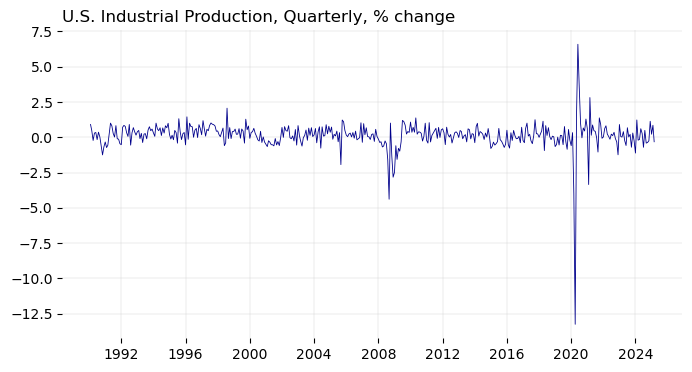

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(INDPRO_pc, '-', color='darkblue', linewidth=0.6)
plt.title('U.S. Industrial Production, Quarterly, % change', loc='left')
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.show()

# 2. LSTAR Model

In [7]:
ro.globalenv['INDPRO_pc'] = INDPRO_pc['INDPRO'] # copy data from Python to R

In [8]:
%%R
LSTAR <- tsDyn::lstar(INDPRO_pc, m=1, d=1, mL=1, mH=1, th=0,
                      starting.control = list(gammaInt=c(2., 5.)), trace=FALSE)
print(LSTAR)


Non linear autoregressive model

LSTAR model
Coefficients:
Low regime:
    const.L      phiL.1 
-10.0313861  -0.8985407 

High regime:
  const.H    phiH.1 
10.135061  1.171979 

 22.08 ng parameter: gamma =

Threshold
Z(t) = + (1) X(t) 

 -3.661 


# 3. Forecast

In [9]:
%%R
h_steps <- 6 # set the forecast time horizon
INDPRO_pc_forecast <- stats::predict(LSTAR, n.ahead=h_steps) # generate forecast

In [10]:
%%R
INDPRO_pc_forecast

[1] 0.01683169 0.10827727 0.13328199 0.14011925 0.14198881 0.14250002


In [11]:
INDPRO_pc_forecast = ro.globalenv['INDPRO_pc_forecast'] # copy data from R to Python
h_steps = int(ro.globalenv['h_steps'][0])

In [12]:
id = INDPRO_pc.index
id_f = pd.date_range(start=id[-1]+pd.DateOffset(1), periods=h_steps, freq='MS')
INDPRO_pc_f = pd.DataFrame(index=id_f, data={'forecast': INDPRO_pc_forecast})

# 4. Plot
Plot part of the original series and the forecast

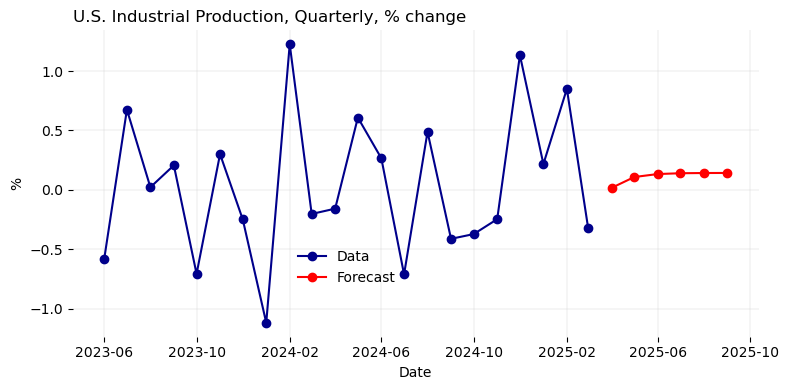

In [13]:
start_plot = pd.to_datetime('2023-06-01')
INDPRO_pc_s = INDPRO_pc[INDPRO_pc.index >= start_plot]

plt.figure(figsize=(8, 4))
plt.plot(INDPRO_pc_s.index, INDPRO_pc_s['INDPRO'], label='Data', color='darkblue', linestyle='-', marker='o')
plt.plot(INDPRO_pc_f.index, INDPRO_pc_f['forecast'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('U.S. Industrial Production, Quarterly, % change', loc='left')
plt.legend(loc=(0.32, 0.15), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()

Plot subset of data and 1-step ahead in-sample forecasts

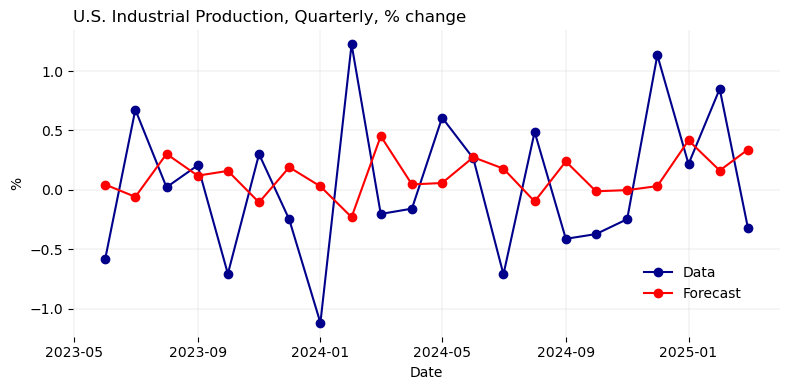

In [14]:
data = INDPRO_pc
f_start = pd.to_datetime('2023-06-01')
T = len(data)
y = data[data.index >= f_start].copy()
s = len(y)
y['y_hat'] = 0.

for j in range(s):
    t = T-s+j
    ydat = data.iloc[:t]
    ro.globalenv['ydat'] = ydat['INDPRO'] 
    ro.r('''LT <- tsDyn::lstar(ydat, m=1, d=1, mL=1, mH=1, th=0,
                         starting.control = list(gammaInt=c(2., 5.)), trace=FALSE)''')    
    ro.r('yh <- stats::predict(LT, n.ahead=1)')   
    yh = ro.globalenv['yh'] 
    y.at[y.index[j], 'y_hat'] = yh

plt.figure(figsize=(8, 4))
# plot data
plt.plot(y.index, y['INDPRO'], label='Data', color='darkblue', linestyle='-', marker='o')
# plot forecast
plt.plot(y.index, y['y_hat'], label='Forecast', color='red', linestyle='-', marker='o')

plt.xlabel('Date')
plt.ylabel('%')
plt.title('U.S. Industrial Production, Quarterly, % change', loc='left')
plt.legend(loc=(0.8, 0.1), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) # labels every 4 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()